# pyoctree example - Shadow casting of 3D model onto plane
---
This notebook loads a stl file of a 3D model and performs shadow casting by creating a grid of rays and detecting if an intersection between these rays and the object occurs.  

Requirements for this notebook:
* pyoctree
* vtk >= 6.2.0
* skimage >= 0.11.3

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, vtk
import skimage
import skimage.feature
sys.path.append('../')
from pyoctree import pyoctree as ot

In [2]:
print vtk.vtkVersion.GetVTKVersion()
print skimage.__version__

6.3.0
0.12.3


In [3]:
# Read in stl file
reader = vtk.vtkSTLReader()
reader.SetFileName("knot.stl")
reader.MergingOn()
reader.Update()
stl = reader.GetOutput()
print "Number of points    = %d" % stl.GetNumberOfPoints()
print "Number of triangles = %d" % stl.GetNumberOfCells()

Number of points    = 38214
Number of triangles = 76428


In [4]:
# Define size of projected image (in pixels)
width, height = 200, 200

In [5]:
# Extract polygon info from stl

# 1. Get array of point coordinates
numPoints   = stl.GetNumberOfPoints()
pointCoords = np.zeros((numPoints,3),dtype=float)
for i in xrange(numPoints):
    pointCoords[i,:] = stl.GetPoint(i)
    
# 2. Get polygon connectivity
numPolys     = stl.GetNumberOfCells()
connectivity = np.zeros((numPolys,3),dtype=np.int32)
for i in xrange(numPolys):
    atri = stl.GetCell(i)
    ids = atri.GetPointIds()
    for j in range(3):
        connectivity[i,j] = ids.GetId(j)

In [6]:
# Create octree structure containing stl poly mesh
tree = ot.PyOctree(pointCoords,connectivity)

In [7]:
# Print out basic Octree data
print "Size of Octree               = %.3fmm" % tree.root.size
print "Number of Octnodes in Octree = %d" % tree.getNumberOfNodes()
print "Number of polys in Octree    = %d" % tree.numPolys

Size of Octree               = 3.115mm
Number of Octnodes in Octree = 2497
Number of polys in Octree    = 76428


In [8]:
# Create rays
xs,xe,ys,ye,zs,ze = stl.GetBounds()
perc = 0.05
xr  = xe-xs
yr  = ye-ys
zr  = ze-zs
xs -= xr*perc
xe += xr*perc
ys -= yr*perc
ye += yr*perc
zs -= zr*perc
ze += zr*perc 
xr = np.linspace(xs,xe,width)
yr = np.linspace(ys,ye,height)
rayPointList = []
for x in xr:
    for y in yr:
        rayPointList.append([[x,y,zs],[x,y,ze]])
rayPointList = np.array(rayPointList,dtype=np.float32)

In [9]:
# Perform intersections
proj  = tree.rayIntersections(rayPointList)
proj  = proj.reshape((width,height))
proj  = proj.astype(float)
proj  = proj[::-1,:]

In [10]:
# Time projection
%timeit -n1 -r1 proj = tree.rayIntersections(rayPointList)

1 loop, best of 1: 2 s per loop


In [11]:
# Perform edge detection
edges = skimage.feature.canny(proj,sigma=1.0)

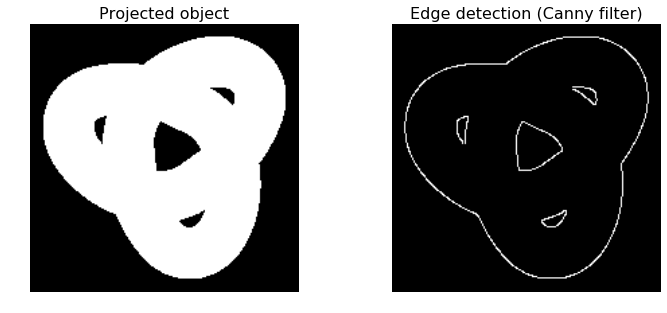

In [12]:
# Plot figures
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4));

ax1.imshow(proj, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Projected object', fontsize=16)

ax2.imshow(edges, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Edge detection (Canny filter)', fontsize=16);

fig.subplots_adjust(wspace=0.1, hspace=0.02, top=0.95, bottom=0.02, left=0.02, right=0.98)

In [13]:
# Create a vtk representation of Octree
tree.getOctreeRep()